In [174]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/carlosfol/My_Documents/Git_Projects/PSI_TRIPS')
import pandas as pd
import seaborn as sns
from scripts.trip_management import DatetimesObj, StrTimes, TripDates

### **ANONYMOUS TRANSPORT COMPANY ANALYSIS 🚛**
First, I will provide a comprehensive overview of the variables included in our dataset because they are in Spanish:
* RECEPCIÓN CUENTAS (RECEIPT OF ACCOUNTS): It shows when the driver delivers his trip-related accounts, such as the signed remission guide, toll road expenses, invoices, and a summary of trip costs. These details are crucial for determining the driver's earnings for the trip they completed, allowing us to calculate the amount they will receive.

* FECHA (DATE): The scheduled date of the trip.
* HORA (HOUR): The scheduled time for the trip.
* CLIENTE (CUSTOMER) : It shows who requested the service.
* MARCA (AUTOMOBILE BRAND): The brand of the automobile used for the trip.
* MODELO (AUTOMOBILE MODEL): The model of the automobile used for the trip. 
* VIN (CHASIS): The number of the automobile chassis used for the trip.
* COLOR: The color of the automobile used for the trip.
* FAMILIA (AUTOMOBILE FAMILY): These can be heavy or light automobiles.
* ORIGEN (ORIGIN): The starting point of the trip.
* DESTINO (DESTINATION): The destination point of the trip. 
* PROVEEDOR (SUPPLIER): Who provides the transportion service in the trip.
* MOTIVO TRASLADO (REASON FOR THE TRIP): Why is the reason of the trip?
* OBSERVACIONES (OBSERVATIONS): The irregularities in the automobile. 
* LOCAL / REGIONAL: The trip was made in Lima or outside the region. 
* NUEVO / SEMINUEVO (NEW / USED): The autombile assigned to the trip is new or used. 
* VOLQUETE (TIPPER TRUCK): Was a Tipper truck used for the trip?
* STATUS (STATUS): The trip status
* CONDUCTOR (DRIVER): Who was the driver assigned to the trip?
* LICENCIA (DRIVER'S LICENSE): The license number of the driver
* PLACA (PLATE): LICENSE PLATE
* GUIA DE REMISIÓN (REFERRAL GUIDE): The referral guide number.
* FECHA DE INICIO (START DATE): When does the trip start?
* HORA LLEGADA CONDUCTOR (DRIVER ARRIVAL TIME): What time did the driver arrive at the meeting point to pick up the automobile?
* HORA DE INICIO DEL TRANSITO (TRANSIT START TIME): What time the driver started the trip.
* FECHA DE LLEGADA (ARRIVAL DATE): When the driver delivered the automobile in the settled destination.
* HORA DE LLEGADA DESTINO (ARRIVAL TIME): The time when the driver delivered the automobile in the final point
* EMBARQUE (SHIPMENT): The Shipment ID
* NRO. TRANSFERENCIA (TRANSFER NUMBER): The Transfer Number ID  
* POR RENDIR S/ (BUDGET): How much money did the driver receive for his expenses during the trip? For exm: 
* FECHA TRANSFERENCIA (TRANSFER DATE): When did the driver receive the money for his expenses?
* COMBUSTIBLE (FUEL): How much fuel has it been necessary to deliver during the trip?
* CINTA REFLECTIVA (REFLECTIVE TAPE): Was it necessary to put a reflective tape to the automobile?
* PARACHOQUE (BUMPER): Was it necessary to implement a bumper to the automobile?
* HORAS DE ESPERA (WAITING HOURS): How many hours did the driver wait at the meeting point to pick up the automobile? If the driver waited x hours and this amount > 2, then the waiting hours = x - 2 
* LAVADO (WASHING): Was it necessary to wash the automobile for the delivery?
* REVISIÓN TÉCNICA (TECHNICAL-MECHANICAL REVIEW): Was it necessary to do a technical-mechanical review for the automobile?
* OTROS (TRIP DETAILS): Additional information about the trip.
* COMENTARIOS (COMMENTS): Additional information about the trip.
* INCIDENTES DE TRANSITO / SINIESTROS (TRAFFIC INCIDENTS): The traffic incident(s) that occurred during the trip.

---

In [175]:
#Load the tranport company dataset
df_TransportCompany = pd.read_excel(
    io = '/home/carlosfol/My_Documents/Git_Projects/PSI_TRIPS/data/TRIPS_MADE.xlsx'
)
#Remove empty spaces in column names
df_TransportCompany.columns = [c.strip() for c in df_TransportCompany.columns]

##### **Data Cleaning** 🗑️

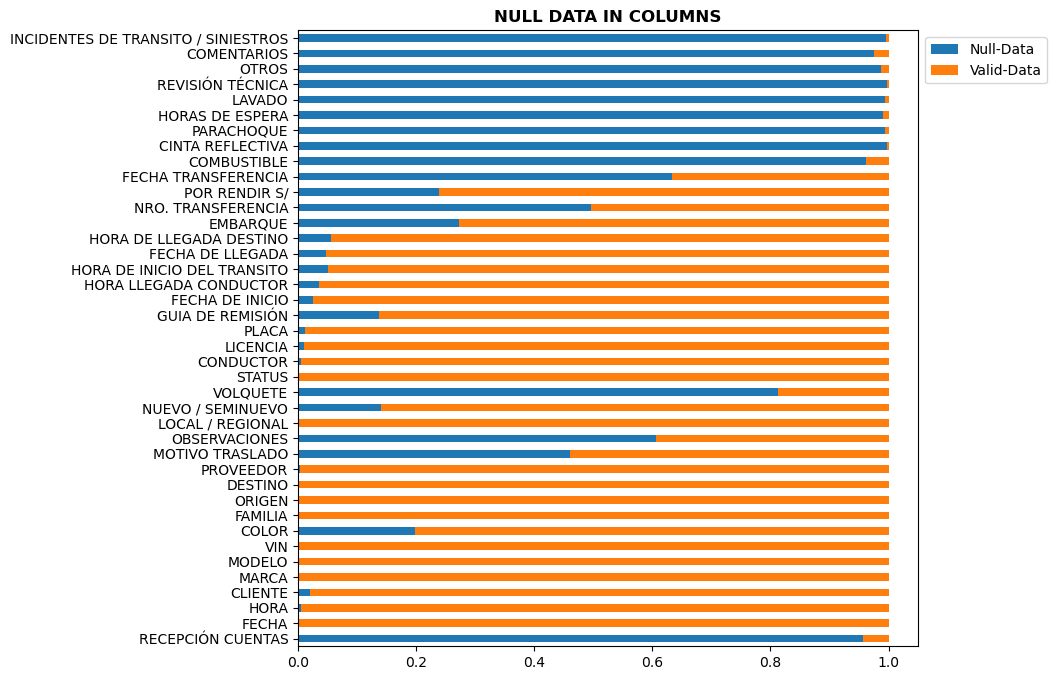

In [176]:
#Let's check the proportion of null data in the df
df_nulldata_columns = pd.DataFrame({
    'Null-Data': df_TransportCompany.isnull().sum(),
    'Valid-Data': df_TransportCompany.notnull().sum()
})
df_nulldata_columns = df_nulldata_columns.div(df_nulldata_columns.sum(axis = 1), 
                                              axis = 0)
#Plot the results
df_nulldata_columns.plot(
    kind = 'barh',
    stacked = True,
    figsize = (8, 8),
)
plt.title('NULL DATA IN COLUMNS', 
          fontdict = {'weight': 'bold'})
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [177]:
total_columns = len( df_TransportCompany.columns )
#Which columns have a high pct of null data (50% <=) ?
more_than_50 = df_nulldata_columns['Null-Data'] >= 0.5
pct = len( df_nulldata_columns[more_than_50].index ) / total_columns
print(f'{pct * 100}% of the columns have a large amount of null data')

32.5% of the columns have a large amount of null data


It's normal to see some columns with a large amount of null data, because there were trips where it was not necessary to put a reflective tape or a bumper, refuel the car, do the Technical-Mechanical Review, etc. So we have to fill these null data with Missing values.

Another point to mention is that we can see at a glance that there are no trips with all null data in all columns. But, let's check if what I say is true.

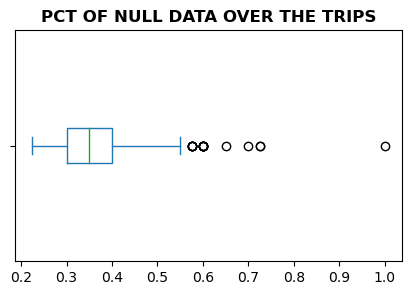

In [178]:
#What is the median of the null attributes in each trip 
total_variables = df_TransportCompany.shape[1]
(
    df_TransportCompany.
    isnull().
    sum(axis = 1).
    div(total_variables, axis=0).
    plot(
        kind = 'box',
        vert = False,
        figsize = (5, 3)
    )
)
plt.title('PCT OF NULL DATA OVER THE TRIPS', 
          fontdict={'weight': 'bold'})
plt.show()

We can see a significant proportion of trips that have a high pct of null data over their attributes. And as I mentioned before, it can be a good explanation that in the vast majority of the trips it was not necessary to implement anything extra (bumper, reflective tape, fuel) on the car and there were no incidents with it.   

In [179]:
#Let's check if there are null trips to remove them
null_trips = df_TransportCompany.isnull().sum(axis = 1)
null_trips = null_trips[null_trips == total_columns].index
print(f'{ len(null_trips) } trip(s) with only null data over its columns')
df_TransportCompany.drop(list(null_trips),
                         axis = 0,
                         inplace = True)

1 trip(s) with only null data over its columns


In [180]:
#Let's fill those columns of extra cost along the trip
first_trip_extra_cost = df_TransportCompany.columns.to_list().index('COMBUSTIBLE')
trip_extra_costs = df_TransportCompany.columns[first_trip_extra_cost:].tolist()
trip_extra_costs.append('OBSERVACIONES')
trip_extra_costs.remove('HORAS DE ESPERA')

for extra_cost in trip_extra_costs:
    df_TransportCompany.loc[:, extra_cost].fillna('Missing', inplace = True)
#Change values from VOLQUETE column
df_TransportCompany['VOLQUETE'].fillna('Not Specified', inplace = True)
#Conditions
used_volquete = df_TransportCompany['VOLQUETE'] == 'SI' #Was it used a VOLQUETE?
not_used_volquete = df_TransportCompany['VOLQUETE'] == 'NO'
#Replace values
df_TransportCompany.loc[used_volquete, 'VOLQUETE'] = 1
df_TransportCompany.loc[not_used_volquete, 'VOLQUETE'] = 0

Well, I fill all the columns that don't necessary to have a validate value in the trip. 

In [181]:
df_TransportCompany.VOLQUETE.unique()

array(['Not Specified', 0, 1], dtype=object)

But, I have a problem with the VOLQUETE column, because there are cases where it was specified if the driver used this type of vehicle or not in the trip. So I will have to try if I can predict this value according to the other variables. Maybe they can give me some help to fill this null data.

---

##### **NULL-DATA IN WAITING HOURS**

This column is the one who has the largest amount of null-data. But, we can know what value has to be in there by substracting the TRANSIT START TIME - DRIVER ARRIVAL TIME and check wheter this difference is greater than 2, because only in these cases can we say that there were waititng hours.

In [182]:
important_columns = ['HORA LLEGADA CONDUCTOR', 'HORA DE INICIO DEL TRANSITO','HORAS DE ESPERA']
df_waiting_hrs = df_TransportCompany.loc[:, important_columns].copy()
#Before calculating the waiting hours, we have to be sure my columns are in the correct dtype
df_waiting_hrs.dtypes

HORA LLEGADA CONDUCTOR         object
HORA DE INICIO DEL TRANSITO    object
HORAS DE ESPERA                object
dtype: object

Everything has an object dtype, so I would get an error if I tried to make operations with them. Also, I have to check which records I can work with, because if there is null data over the column **HORA LLEGADA CONDUCTOR** or **HORA DE INICIO DE TRANSITO**, then it will be impossible to obtain the waiting hours in that trip. So I will have to filter them.

In [183]:
# 1) To state if the record is validate or not it's not necessary the HORAS DE ESPERA column
valid_records = (df_waiting_hrs.iloc[:, :-1].isnull() * 1).sum(axis = 1)
# 2) Set a column that tells me if the record is valid or not (1 = True, 0 = False)
valid_records = np.where(valid_records == 0, 1, 0)
df_waiting_hrs['VALID DATA'] = valid_records

/tmp/ipykernel_518/2328701768.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_vtimes_prop['INVALID TIMES'] = df_vtimes_prop[0] - df_vtimes_prop[1]


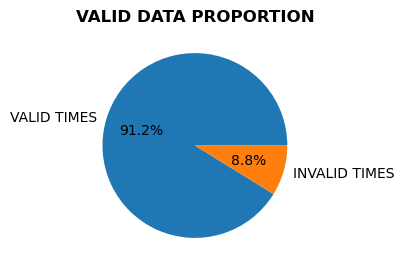

In [184]:
def check_format_time(time: datetime) -> int:
    """
    Check if the valid data respect 
    the format HOURS:MINUTES:SECONDS
    """
    time = str(time)
    f_time = '00:00:00' 
    valid_len = len(f_time)
    d2_dot = [idx for idx, ch in enumerate(f_time) if ch == ':'] #Position of :
    try:
        has_d2_dot = np.all([True for position in d2_dot if time[position] == ':'])
    except IndexError:
        has_d2_dot = False
    if (len(time) == valid_len) and (has_d2_dot):
        return 1
    else:
        return 0

df_waiting_hrs['VALID TIMES'] = df_waiting_hrs.pipe(
    lambda df: df['HORA LLEGADA CONDUCTOR'].apply(check_format_time) +
                df['HORA DE INICIO DEL TRANSITO'].apply(check_format_time)
)
# Check if both times are valid
valid_times = np.where(df_waiting_hrs['VALID TIMES'] == 2, 1, 0)
df_waiting_hrs['VALID TIMES'] = valid_times
# Check the proportion of valid times in valid data
df_vtimes_prop = df_waiting_hrs.iloc[:, -2:].sum()
df_vtimes_prop['INVALID TIMES'] = df_vtimes_prop[0] - df_vtimes_prop[1]
# Graph
df_vtimes_prop[1:].plot(
    kind = 'pie',
    title = 'VALID DATA',
    autopct = '%.01f%%',
    figsize = (3, 3)
)
plt.title('VALID DATA PROPORTION', fontdict={'weight': 'bold'})
plt.show()

As you can see, we can have valid data over the columns **HORA LLEGADA CONDUCTOR** and **HORA DE INICIO DE TRANSITO**. However, it's not necessary consistent data that we can use to calculate the waiting hours. So we need to check what kind of values there are across the group of invalid times.

In [185]:
# Create a df that only contains the records who have invalid times
is_valid = df_waiting_hrs['VALID DATA'] == 1
inv_time = df_waiting_hrs['VALID TIMES'] == 0
df_inv_times = df_waiting_hrs.loc[is_valid & inv_time, df_waiting_hrs.columns[:-3]].copy()
# Let's check the 5 most common values and their frequencies in each variable.
dict_common_val = dict()
for col in df_inv_times.columns:
    df_common_val = pd.DataFrame( 
                    df_inv_times.loc[:, col].value_counts()[:5].reset_index()
                    )
    df_common_val.columns = ['Value', 'Frequency']
    dict_common_val[col] = df_common_val
# Make a merge to find similar values between the variables
pd.merge(
    left = dict_common_val['HORA LLEGADA CONDUCTOR'],
    right = dict_common_val['HORA DE INICIO DEL TRANSITO'],
    on = 'Value',
    suffixes = ['_HLC', '_HIT'] #initials
)

,Value,Frequency_HLC,Frequency_HIT
0,-,106,136
1,FALSO FLETE,16,21
2,CANCELADO,5,5
3,---,5,5


Now, it's important to clarify the meaning of 2 words at this point:
* **FALSO FLETE (FAKE CALL):** It occurs when the customer cancels the service at the last minute. And the transport company has to charge an amount of money for the offense committed 
* **CANCELADO:** It happens when the customer cancels the service in time. So, any action will be taken about it.

It makes sense that I can't calculate anything with this kind of record, because the trip didn't happen. So, the plan is to exclude them and understand why there are values like '-' or '---'.  

In [186]:
# Find those trips that have '-' as a value
# dat: driver arrival time
# tst: transit start time 
dat = df_inv_times.iloc[:, 0].astype(str).str.contains('-')
tst = df_inv_times.iloc[:, 1].astype(str).str.contains('-')
idx_hyphen_val = df_inv_times[dat | tst].index
df_hyphen_val = df_TransportCompany.iloc[idx_hyphen_val, :].copy()

There are 3 columns can give me useful information about why there is this kind of values across these columns:
* **OBSERVACIONES (OBSERVATIONS):** This variable mentions about the irregularities with the assigned automobile in the trip.
* **COMENTARIOS (COMMENTARIES):** It gives the similar information than OBSERVACIONES column
* **STATUS:** It tells me if the trip was cancelled, finished or whatever. 

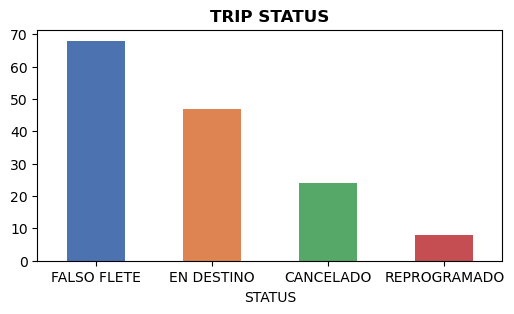

In [187]:
#Plot the Status values
my_pltt = sns.color_palette("deep")
(
    df_hyphen_val.
    loc[:, 'STATUS'].
    value_counts().
    plot(
        kind = 'bar',
        rot = 0,
        color = my_pltt,
        figsize = (6, 3)
    )
)
plt.title('TRIP STATUS', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()

Well, it's very strange to see that there are trips that were made despite the fact that there was no valid time registered either in **HORA LLEGADA CONDUCTOR** and **HORA DE INICIO DE TRANSITO** or both. How can the transport company know if it has to charge the customer for hours of waiting without this information? This was a significant mistake by who did not do it.

On the other hand, we can see the other status are **FALSO FLETE (FAKE CALL)**, **CANCELADO (CANCELED)** and **REPROGRAMADO (REPROGRAMMED)**. And now it's more understandable why they decided to fill these camps with '-' values, because it means that in this group there are the trips that were not made. So, the plan is to change these values for one by default to make easier the task of filterting when we want to calculate the waiting hours, since as we could see there are some that are '-', '--' or '---'. Likewise, it's necessary to do the same with those ones that have values like **FALSO FLETE** or **CANCELADO**.

On the other hand, I still have null data across these columns, but I've decided to fill them with the same default value.

In [188]:
# Hyphen:
df_TransportCompany.loc[idx_hyphen_val, important_columns[:-1]] = 'Unregistered'
# Fake call or canceled:
fake_call_or_cancelled = df_TransportCompany.iloc[:, [23, 24]].isin(
    ['FALSO FLETE', 'CANCELADO']
).any(axis = 1)
df_TransportCompany.loc[fake_call_or_cancelled, important_columns[:-1]] = 'Unregistered'
# Null data: dat -> driver arrival time ; tst -> transit start time 
null_dat = df_TransportCompany.iloc[:, 23].isnull()
null_tst = df_TransportCompany.iloc[:, 24].isnull()
null_times = df_TransportCompany.loc[null_dat | null_tst, important_columns[:-1]].fillna(
    'Unregistered'
)
df_TransportCompany.loc[null_dat | null_tst, important_columns[:-1]] = null_times
# Invalid waiting hours
unregistered_cond = df_TransportCompany.iloc[:, [23, 24]].isin(
    ['Unregistered']
).any(axis = 1)
df_TransportCompany.loc[unregistered_cond, 'HORAS DE ESPERA'] = 'Invalid'

We should make sure that all the trips that have invalid times according to the df_waiting_hours have the value 'Invalid' in the **HORAS DE ESPERA** column. 

In [189]:
not_unregistered = [df_TransportCompany[col] != 'Unregistered' 
                   for col in important_columns[:-1]]
invalid_times = df_waiting_hrs['VALID TIMES'] == 0
(
    df_TransportCompany.loc[
    not_unregistered[0] & not_unregistered[1] & invalid_times,
    important_columns
    ]
)

,HORA LLEGADA CONDUCTOR,HORA DE INICIO DEL TRANSITO,HORAS DE ESPERA
1304,15:51:00,16:09:00.,NaN
2025,0.791667,0.820833,NaN


As you can see, we have two trips that don't respect what we mentioned before:
* In the column **HORA DE INICIO DEL TRANSITO** of row 1304, the times has a dot at the end. So, this is solved by removing it.
* In row 2025, there are two times expressed in float numbers. That doesn't make sense, that's why we're gonna replace them with 'Unregistered' value.

In [190]:
#Typo at the end
v_time = str(df_TransportCompany.loc[1304, important_columns[1]]).replace('.', '')
df_TransportCompany.loc[1304, important_columns[1]] = v_time
#Float values 
df_TransportCompany.loc[2025, important_columns[:-1]] = 'Unregistered'
df_TransportCompany.loc[2025, important_columns[-1]] = 'Invalid'

In [191]:
def are_valid_whours(waiting_hrs: pd.Series) -> pd.Series:
    """
    Check if the driver had to wait 
    2 hours or more to start with the trip.
    """
    waiting_hrs[waiting_hrs < 2] = 'Not WH'
    return waiting_hrs

def convert_time_to_float(times: pd.Series) -> pd.Series:
    """
    It converts the time in float where 
    the decimal part is the hours and the 
    fractional part is the minutes
    """
    float_times = times.astype(str).apply(
        lambda time: time[:2] + '.' + time[3:5] #HH:MM:SS
        ).astype(float)
    return float_times

valid_dat = df_TransportCompany['HORA LLEGADA CONDUCTOR'] != 'Unregistered'
valid_tst = df_TransportCompany['HORA DE INICIO DEL TRANSITO'] != 'Unregistered'
df_float_times = df_TransportCompany.loc[valid_dat & valid_tst, important_columns[:-1]].apply(
    convert_time_to_float
)
df_TransportCompany.loc[valid_dat & valid_tst, 'HORAS DE ESPERA'] = are_valid_whours(
        (df_float_times.iloc[:, 1] - df_float_times.iloc[:, 0]).round(2)
        )
#Check that there is no null data
(df_TransportCompany[important_columns].isnull() * 1).sum()

/tmp/ipykernel_518/2986059360.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Not WH' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  waiting_hrs[waiting_hrs < 2] = 'Not WH'


HORA LLEGADA CONDUCTOR         0
HORA DE INICIO DEL TRANSITO    0
HORAS DE ESPERA                0
dtype: int64

---

##### **NULL-DATA IN TRANSFER DATE**

Another column that we have a significant amount of null data is **FECHA TRANSFERENCIA (Transfer Date)**. And as it was mentioned at the beginning of this noteebook, it consists of the date that the driver gets the necessary money for his expenses during the trip.

The plan is to use the same date as the **FECHA INICIO (Start Date)** column, because the driver always receive his transfer on the same day that he starts the trip. But first, we have to check if these dates are less or equal than those in **FECHA DE LLEGADA (Arrival date)** column, otherwise that wouldn't be consistent. 

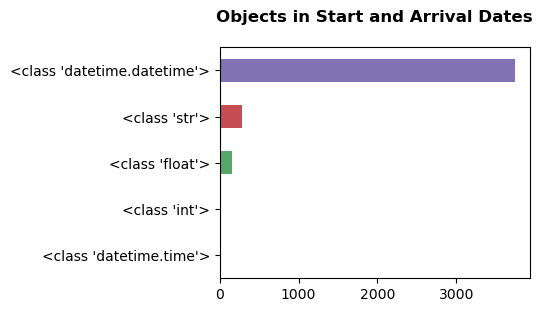

In [192]:
(
    df_TransportCompany.
    melt(
        value_vars = ['FECHA DE INICIO',
                      'FECHA DE LLEGADA'],
        value_name = 'DATES'
        ).
    apply(
        lambda x: type(x['DATES']),
        axis = 1
        ).
    value_counts().
    sort_values(
        ascending = True
        ).
    plot(
        kind ='barh',
        color = my_pltt,
        figsize = (4, 3)
    )
)
plt.title('Objects in Start and Arrival Dates\n', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()

There are different objects surrounding these two columns and this will be a problem when we want to perform operations with them. So it's important to cast them to datetime.datetime object. But meanwhile, we can see if those that have the correct type accomplish the previous condition (ARRIVAL TIME >  START TIME).

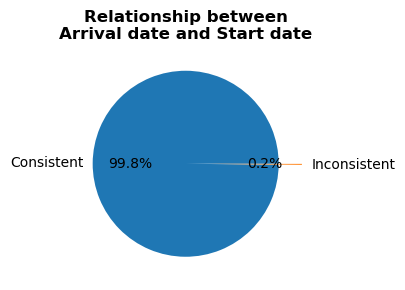

In [193]:
trip_dates = DatetimesObj(df_tc=df_TransportCompany)
(
    pd.Series({
        'Consistent': trip_dates.filter_by_relationship().shape[0],
        'Inconsistent': trip_dates.filter_by_relationship(consistent=False).shape[0]
        }).
    plot(
        kind = 'pie',
        explode = [0, 0.25],
        autopct = '%.01f%%',
        figsize=(3, 4)
    )
)
plt.title('Relationship between\nArrival date and Start date', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()


We'll need to check other variables to confirm if either the start date or the arrival date is incorrect to replace it. And the following columns can give us relevant information about it:
* **FECHA**: When the trip was recorded in the dataset.
* **ORIGEN** and **DESTINO**: These columns make up the route. And if we see others with the same data, we can estimate the journey time.
* **FECHA DE TRANSFERENCIA**: If there's not a null value, then it can help us to confirm that the start date is correct.

In [194]:
(
    trip_dates.
    filter_by_relationship(consistent=False).
    loc[:, ['FECHA', 'FECHA DE INICIO', 'FECHA DE LLEGADA', 
         'ORIGEN', 'DESTINO', 'FECHA TRANSFERENCIA']]
)

,FECHA,FECHA DE INICIO,FECHA DE LLEGADA,ORIGEN,DESTINO,FECHA TRANSFERENCIA
403,2023-08-07,2023-08-07 00:00:00,2023-07-08 00:00:00,SUC. TRUJILLO,SUC. HUARAZ,NaN
476,2023-08-09,2023-08-09 00:00:00,2023-08-08 00:00:00,MACROPOLIS,RMB VES,2023-08-09 00:00:00
1631,2023-09-18,2023-09-18 00:00:00,2023-08-19 00:00:00,CD LURIN,SUC. AREQUIPA,18/09 Y 20/09


All the start dates are correct by checking in **FECHA** and **FECHA TRANSFERENCIA** column, even though there's a NaN value in record 403, but we'll asume that the start date is correct anyway. On the other hand, we'll have to look at other trips with a similar route to estimate the journey time and thus calculate the values in **FECHA DE LLEGADA** column.

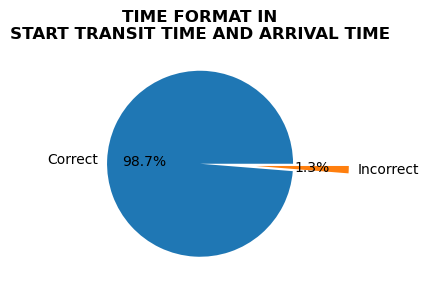

In [195]:
# Use the columns Transit Start Time and Arrival Time to check the format time
start_arr_times = trip_dates.filter_by_relationship().loc[:, 
                                                   ['HORA DE INICIO DEL TRANSITO', 
                                                    'HORA DE LLEGADA DESTINO']
                                                   ].copy()
start_arr_times['Correct_Format'] = start_arr_times.loc[:, 
                                                        ['HORA DE INICIO DEL TRANSITO',
                                                         'HORA DE LLEGADA DESTINO']].map(
                                                             check_format_time
                                                             ).sum(axis = 1)
# Visualize the proportion of correct times in both columns
time_format = start_arr_times['Correct_Format'].value_counts()
time_format[1] = time_format[[1, 0]].sum(); time_format = time_format[[2, 1]]
time_format.index = ['Correct', 'Incorrect']
time_format.name = None
time_format.plot(
    kind = 'pie',
    autopct = '%.01f%%',
    figsize = (3, 4),
    explode = (0, 0.6)
)
plt.title('TIME FORMAT IN\nSTART TRANSIT TIME AND ARRIVAL TIME', 
          fontdict = {'weight': 'bold',
                      'size': 'large'})
plt.show()

In [196]:
start_arr_times['Correct_Format'] = start_arr_times.apply(
    lambda x:
        check_format_time(x['HORA DE INICIO DEL TRANSITO']) + 
        check_format_time(x['HORA DE LLEGADA DESTINO']),
        axis = 1
    )
start_arr_times.Correct_Format.value_counts()

Correct_Format
2    1790
1      14
0       9
Name: count, dtype: int64

We've removed all the null data over the **HORA DE INICIO DEL TRANSITO** column in the above section (NULL DATA IN WAITING HOURS), so the most likelihood is that there are Unregistered values in this column and for this reason we get times with a incorrect format.

In [197]:
(
    start_arr_times.loc[
        start_arr_times['Correct_Format'] != 2,
        'HORA DE INICIO DEL TRANSITO'
        ].
    value_counts()[:5]
)

HORA DE INICIO DEL TRANSITO
Unregistered    12
13:15:00         1
13:51:00         1
17:01:00         1
09:50:00         1
Name: count, dtype: int64

In [198]:
(
    start_arr_times.loc[
        start_arr_times['HORA DE INICIO DEL TRANSITO'] == 'Unregistered',
        'HORA DE LLEGADA DESTINO'
        ].
    value_counts(
        dropna = False
    )
)

HORA DE LLEGADA DESTINO
NaN         8
-           1
17:58:00    1
09:49:00    1
20:24:00    1
Name: count, dtype: int64

It makes sense there are null data in the arrival time column, since these trips weren't made. So we can fill them with Unregistered too. And the one that has '-' as its value should have to change for the same.

In [199]:
start_arr_times['HORA DE LLEGADA DESTINO'].fillna('-', inplace = True)
null_arr_time = start_arr_times[
    start_arr_times['HORA DE LLEGADA DESTINO'] == '-'
    ].index
df_TransportCompany.loc[null_arr_time, 'HORA DE LLEGADA DESTINO'] = 'Unregistered'

On the other hand, we have a inconsistent problem here. Since if it supposed that there wasn't a start transit time, how is it possible that there are times registered in arrival times?

In [200]:
unrgt_times = start_arr_times[
        (start_arr_times['HORA DE INICIO DEL TRANSITO'] == 'Unregistered')
        & (start_arr_times['HORA DE LLEGADA DESTINO'] != '-')
].index
(
    df_TransportCompany.
    loc[ 
    unrgt_times,
    'STATUS'
    ].
    value_counts()
) 

STATUS
EN DESTINO    3
Name: count, dtype: int64

The status of the trips that have a consistent time in **ARRIVAL TIME** column, but an Unregistered value in the **START TRANSIT TIME**, is **EN DESTINO (AT DESTINATION)**. This means that they were made. But, it's pointless. So this data won't be useful for estimating the journey time, so we'll fill these values with Unregistered. 

In [201]:
df_TransportCompany.loc[unrgt_times, 'HORA DE LLEGADA DESTINO'] = 'Unregistered'

In [202]:
(
    start_arr_times[
    (start_arr_times['Correct_Format'] != 2)
    & (start_arr_times['HORA DE INICIO DEL TRANSITO'] != 'Unregistered')
    & (start_arr_times['HORA DE LLEGADA DESTINO'] != '-')
    ]
)

,HORA DE INICIO DEL TRANSITO,HORA DE LLEGADA DESTINO,Correct_Format
1332,07:45:00,16:23:00.,1
1734,12:34:00,6.51.00,1
1963,16:01:00,18:38:00 a. m.,1


In [203]:
# Fix the last trips with an inconsistent time in ARRIVAL TIME column
df_TransportCompany.loc[1332, 'HORA DE LLEGADA DESTINO'] = '16:23:00'
df_TransportCompany.loc[1734, 'HORA DE LLEGADA DESTINO'] = '06:51:00'
df_TransportCompany.loc[1963, 'HORA DE LLEGADA DESTINO'] = '18:38:00'
# Update the content
trip_dates.dt_table = df_TransportCompany 

Once we've fixed all the start transit times and arrival times of those trips that have datetime objects over these columns and respect the condition: **Start Date < Arrival Date**. We'll be able to calculate the arrival date in those trips that don't fulfill the condition and estimate the arrival times where there are 'Unregistered' values, despite the fact that they have a start transit time.    

In [204]:
# Inconsistent arrival times
incon_arr_times = trip_dates.get_correct_arr_date(
    trip_dates.filter_by_relationship(consistent=False)
    )
# Unregistered arrival times
unrg_arr_times = trip_dates.filter_by_relationship()
unrg_arr_times = unrg_arr_times[unrg_arr_times.apply(
    lambda x: x['HORA DE LLEGADA DESTINO'] == 'Unregistered' and
        x['HORA DE INICIO DEL TRANSITO'] != 'Unregistered',
        axis = 1
)]
unrgt_arr_times = trip_dates.get_correct_arr_date(unrg_arr_times)
# Combine them 
correct_arr_dates = pd.concat([incon_arr_times, unrgt_arr_times])
# Reeplace them in the original db
df_TransportCompany.loc[correct_arr_dates.index, 'FECHA DE LLEGADA'] = correct_arr_dates.apply(
    lambda x: x.date()
)
df_TransportCompany.loc[correct_arr_dates.index, 'HORA DE LLEGADA DESTINO'] = correct_arr_dates.apply(
    lambda x: x.time()
)
# Update the content
trip_dates.dt_table = df_TransportCompany
# Autofill the transfer date column with the start dates
df_TransportCompany.loc[
    trip_dates.dt_table.index,'FECHA TRANSFERENCIA'
    ] = df_TransportCompany.loc[
        trip_dates.dt_table.index, 'FECHA DE INICIO'
        ]


Now, we have to deal with those trips that have another kind of dtype in these columns. Let's start with those that are str objects and try to cast them to datetime objects.

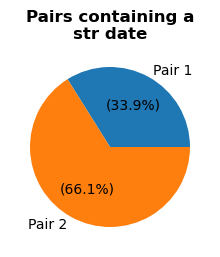

In [205]:
df_strtimes = StrTimes(df_tc=df_TransportCompany).presence_in_db()
groups = ['Pair %s' %group 
          for group in df_strtimes.index.get_level_values(level=0).unique()]
# Plot 
fig = plt.figure(figsize=(2, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.pie(
    x = df_strtimes.freq.unique(), 
    autopct = '(%.1f%%)', 
    labels = groups,
    )
ax.set_title('Pairs containing a\nstr date', fontdict={'weight': 'bold'})
plt.show()

In [206]:
df_strtimes

freq
Pair Date             Dtype                            
1    FECHA DE INICIO  <class 'datetime.datetime'>    59
     FECHA DE LLEGADA <class 'str'>                  59
2    FECHA DE INICIO  <class 'str'>                 115
     FECHA DE LLEGADA <class 'str'>                 115

As you can see, we have two groups with str values. One where both dates are strings and the other where the arrival date is the only one. So, let's find out the reason for this. 

In [207]:
# Get the groups
groups = TripDates(df_tc=df_TransportCompany)
pair_1 = groups.choose_dtypes(dtype_dd=datetime, dtype_ad=str)
pair_2 = groups.choose_dtypes(dtype_ad = str, dtype_dd=str)
(
    pair_1['FECHA DE LLEGADA']
    .value_counts()
)

FECHA DE LLEGADA
-              50
FALSO FLETE     9
Name: count, dtype: int64

In the first group, there are trips that weren't made and others where the arrival date was filled with a '-'.
Recall, **FALSO FLETE (Fake call)** means when the customer cancels the service at the last moment. 

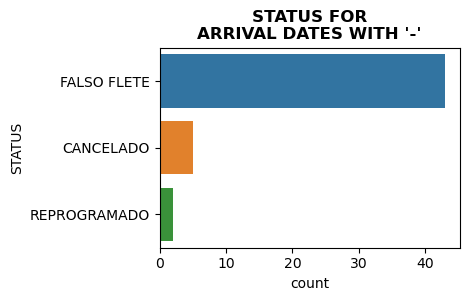

In [208]:
fig  = plt.figure(figsize=(3, 2))
ax = fig.add_axes([0, 0, 1, 1])
(
    pd.merge(
        left = pair_1[pair_1['FECHA DE LLEGADA'] == '-'], 
        right = df_TransportCompany[['STATUS']],
        left_index=True, right_index=True
    ).
    pipe(
        lambda df: 
            sns.countplot(
                data=df, y = 'STATUS',
                )
    )
)
ax.set_title("STATUS FOR\nARRIVAL DATES WITH '-'", fontdict={'weight': 'bold'})
plt.show()


It turns out that they are also trips that weren't made: **FALSO FLETE (FAKE CALL)**, **CANCELADO (CANCELLED)** and **REPROGRAMADO (REPROGRAMMED)**. And if the data is consistency, then we will be in the same situation with the **ARRIVAL TIME** column:

In [209]:
(
    pd.merge(
        left = pair_1,
        right = df_TransportCompany.loc[:, ['HORA DE LLEGADA DESTINO']],
        left_index=True, right_index=True
    ).
    value_counts('HORA DE LLEGADA DESTINO')
)

HORA DE LLEGADA DESTINO
-              50
FALSO FLETE     9
Name: count, dtype: int64

Ta-da! So, we need to fill the columns related with the dates of these trips with Unregistered values.

In [210]:
dates_columns = ['FECHA DE INICIO', 'FECHA DE LLEGADA', 'FECHA TRANSFERENCIA',
                 'HORA DE INICIO DEL TRANSITO', 'HORA DE LLEGADA DESTINO']
df_TransportCompany.loc[pair_1.index, dates_columns] = 'Unregistered'
